In [ ]:
#modelling of second model
#those that were sold elsewhere but not in these shops
#do you drop those products which only sold total of 1's on average in last 3 months?  Does that make it easier for the mod to find something?

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
df=pd.read_csv("/home/cdsw/train_for_mod2_v1.csv")

In [88]:
#there are 118k observations here - if I remove those where number shops were 1 or less last month
#this is about trying to predict sales in new shops, seen that tend to extend
df_check=df
df_check["AV3Months"]=df.loc[: , "Shop_min3":"Shop_min1"].mean(axis=1)
df_check2=df_check[df_check.AV3Months >1]
df_check2.drop(df_check2.columns.to_series().loc["Unnamed: 0":"shop_id"],axis=1,inplace=True)

df_check2.columns

#this means need to look up the amount of shops sold in for that product, and if 1 or less, & not in another score then predicting zero

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Index(['S&P_min9', 'S&P_min8', 'S&P_min7', 'S&P_min6', 'S&P_min5', 'S&P_min4',
       'S&P_min3', 'S&P_min2', 'S&P_min1', 'Target', 'Prod_min9', 'Prod_min8',
       'Prod_min7', 'Prod_min6', 'Prod_min5', 'Prod_min4', 'Prod_min3',
       'Prod_min2', 'Prod_min1', 'Shop_min9', 'Shop_min8', 'Shop_min7',
       'Shop_min6', 'Shop_min5', 'Shop_min4', 'Shop_min3', 'Shop_min2',
       'Shop_min1', 'TotShop_min9', 'TotShop_min8', 'TotShop_min7',
       'TotShop_min6', 'TotShop_min5', 'TotShop_min4', 'TotShop_min3',
       'TotShop_min2', 'TotShop_min1', 'PPStd_min9', 'PPStd_min8',
       'PPStd_min7', 'PPStd_min6', 'PPStd_min5', 'PPStd_min4', 'PPStd_min3',
       'PPStd_min2', 'PPStd_min1', 'AV3Months'],
      dtype='object')

In [89]:
#split into train and test set
Y1=df_check2[["Target"]]
X1=df_check2.drop(["Target"],axis=1)

X_train1, X_test1,Y_train1, Y_test1 = train_test_split(X1,Y1,test_size=0.3, 
                                                   random_state=428)

In [75]:
import time
start = time.time()

# Instantiate model with 1000 decision trees & minimum 5 leafs
rf2 = RandomForestRegressor(n_estimators = 1000, min_samples_leaf=5,random_state = 428)
# Train the model on training data
rf2.fit(X_train1, Y_train1.values.ravel())

end = time.time()
time_taken = end - start
print('Time: ',time_taken)

Time:  325.3745172023773


In [76]:
compare2.isnull().sum()

Target    0
preds2    0
dtype: int64

In [77]:
#Create a view to be able to see the differences in performance & evaluate the RMSE
compare=Y_test1
compare.reset_index(drop=True,inplace=True)
#compare.columns=["Target"]

yhat2=pd.Series(rf2.predict(X_test1))
compare["preds2"]=round(yhat2,0).astype("int64")
#compare2=compare.notnull()
#There is a lot which hasnot been sold in many months - will predict zeros for these
#adds=pd.DataFrame({"Target": np.repeat(0,105787),"preds2" : np.repeat(0,105787)})

#compare2=pd.concat([compare, adds],axis=0)
print("Pure RMSE based only on present data:", mean_squared_error(compare.Target,compare.preds2)**0.5)
#print("RMSE with assumed 0's of long absent data:",mean_squared_error(compare2.Target, compare2.preds2)**0.5)

Pure RMSE based only on present data: 0.5952289546696087


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [90]:
Y1.mean()

Target    0.16617
dtype: float64

In [79]:
print("Observation Predicted:", len(compare))
print("Of which were 0:", len(compare[compare.preds2==0]))

Observation Predicted: 33915
Of which were 0: 30558


In [80]:
#want to see of those not predicted 0, were they sold there before? ie does this prediction give me anything
# test_features=X_test1.reset_index()
testset=pd.concat([X_test1.reset_index(),compare], axis=1)
notzeros=testset[testset.preds2!=0]
notzeros["priorsold"]=notzeros.loc[:,"S&P_min9":"S&P_min1"].sum(axis=1)
notzeros.groupby(["priorsold"])["S&P_min1"].count().reset_index(name="CountPriorSales").transpose()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,114,115
priorsold,0,1,2,3,4,5,6,7,8,9,...,210,216,217,237,258,305,347,370,429,752
CountPriorSales,413,459,286,212,249,174,143,128,140,93,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
#so 400 of the 3000 had no prior sales whatsoever... prior prediction removed those where nothing in last 3 months
# add in the priors of the 3 months? does this tell me anything new?

In [81]:
#of those that were predicted zero -30k- how many were correct
zeros=testset[testset.preds2==0]
print("Number which predicted as zero:", len(zeros))
print("Num which were actually zero:", len(zeros[zeros.Target==0]))
print("Accuracy here:", round(len(zeros[zeros.Target==0])/len(zeros)*100,0) ,"%")

Number which predicted as zero: 30558
Num which were actually zero: 29447
Accuracy here: 96.0 %


In [82]:
conf_mat = pd.crosstab(testset['Target'], testset['preds2'], rownames=['Actual'], colnames=['Predicted'])
conf_mat.head()

Predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16
Actual,,,,,,,,,,,,,,,,
-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,29447,1286,100,23,12,2,2,0,1,0,0,0,0,0,0,0
1,988,854,137,38,13,2,2,2,1,0,0,0,0,0,0,0
2,107,275,84,36,14,7,2,1,0,0,0,0,0,0,0,0
3,13,93,47,26,14,2,3,1,0,0,0,0,0,0,0,0


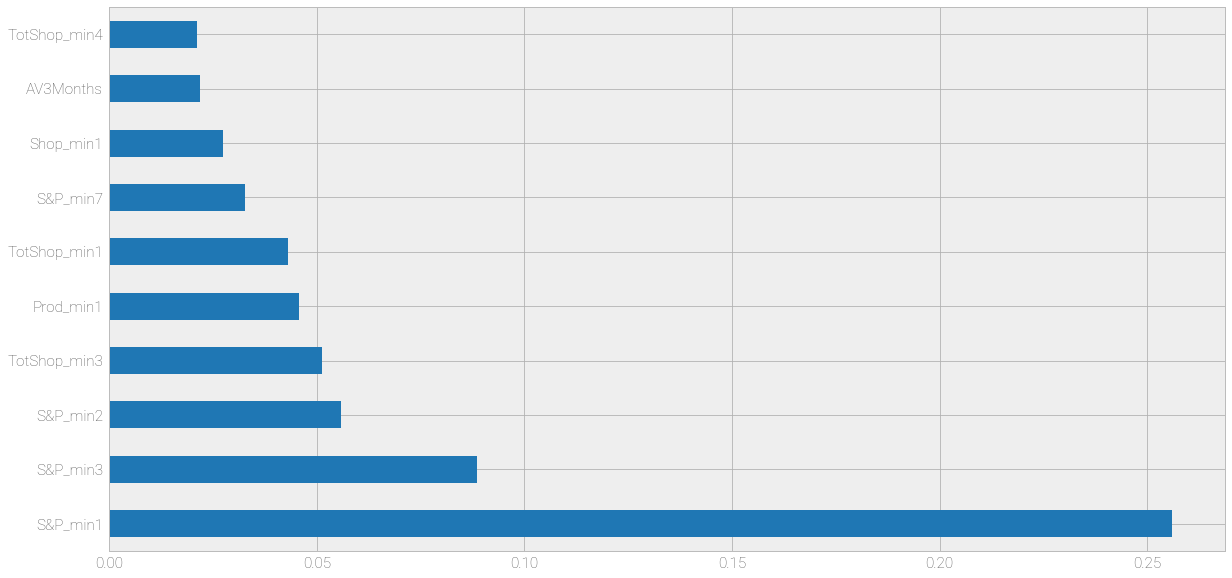

In [85]:
feat_importances = pd.Series(rf2.feature_importances_, index=X_train1.columns)
plt.figure(figsize=(20,10)) 
plt.rcParams.update({'font.size': 22})
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
#so next would be to take this and predict on a new November data set - run 2 different combinations
#where there were no predictions before, take these but otherwise model 1
# variant 2 take this where there are new predictions and the other where not

In [86]:
with open('/home/cdsw/Models/mod2_rf_1000_min5_v2', 'wb') as f:
    pickle.dump(rf2, f)